# Correlations within genes

In [6]:
# we will be using a data handling library called pandas
# which is basically a python spreadsheet

import pandas as pd

# this is here to shut off some annoying warnings from pandas
pd.options.mode.chained_assignment = None

# matplotlib is one of the main plotting libraries we're going to use
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline


# the other plotting library is seaborn - we'll use both during the class

import seaborn as sns

# numpy and scipy are for handling numerical and scientific data

import numpy as np
import scipy as sp

import statsmodels.formula.api as smf # basic statistical modeling

## From last time

In [11]:
# annotation file from NCBI
annot = pd.read_csv("~/Downloads/E_coli_K12_ProteinTable167_161521.txt",sep='\t')
annot.head()

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase
4,chr,NC_000913.3,5234,5530,+,944747,yaaX,b0005,NP_414546.1,98,-,DUF2502 domain-containing protein YaaX


In [12]:
# genome file from NCBI
genome_by_line = pd.read_csv("~/Downloads/E_coli_K12-sequence.fasta.txt")
genome_by_line.head()

,>NC_000913.3 Escherichia coli str. K-12 substr. MG1655,complete genome
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,NaN
1,TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACT...,NaN
2,TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACA...,NaN
3,ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGAC...,NaN
4,CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGA...,NaN


In [13]:
# convert genome_by_line table into a single genome string
genome = ""
for index, row in genome_by_line.iterrows():
    genome = genome + row[0] 
genome[0:100]

'AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT'

In [8]:
# Make a python dictionary of the standard genetic code
gencode = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
    'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'}

In [14]:
# this works like a vector, except instead of providing a 
# numerical index in brackets, use he "key" to retrieve the
# "value"
gencode["ATA"]

'I'

In [16]:
# retrieve a coding sequence of a gene based on its start and stop
# remember the "off-by-one"
# also remember that by sloppy convention, start/stop refers to 
# coding sequence, and omits UTR
annot.head(1)

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide


In [17]:
# so using "Start" puts you one nucleotide into the coding sequence
genome[190:255]

'TGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA'

In [20]:
# so we need to subtract one
genome[189:255]

'ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA'

In [29]:
# generalize for gene i
i = 0
CDS = genome[annot.iloc[i]['Start']-1 : annot.iloc[i]['Stop']]
print(CDS)

ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA


In [27]:
# for convenience, lets store the length of the gene
gene_len = annot.iloc[0]['Stop'] - annot.iloc[i]['Start'] + 1
print(gene_len)

66


In [32]:
# check that we can correctly extract the codons 
for j in range(0,gene_len,3):
    codon = CDS[j:j+3]
    print(codon)

ATG
AAA
CGC
ATT
AGC
ACC
ACC
ATT
ACC
ACC
ACC
ATC
ACC
ATT
ACC
ACA
GGT
AAC
GGT
GCG
GGC
TGA


In [33]:
# now combine this to with the genetic code table to 
# infer the peptide sequence
peptide = ''
for j in range(0,gene_len,3):
    codon = CDS[j:j+3]
    peptide = peptide + gencode[codon]
print(peptide)

MKRISTTITTTITITTGNGAG_


In [69]:
# so we can elevate this to a function
def translate(CDS):
    peptide = ''
    for j in range(0,len(CDS),3):
        codon = CDS[j:j+3]
        peptide = peptide + gencode[codon]
    return peptide

In [70]:
translate(CDS)

'MKRISTTITTTITITTGNGAG_'

## three and six frame translation

In [107]:
# given a sequence that on the correct strand,
# but is not necessarily "in frame" 
# lets try to find the frame
# we have code to translate
test = genome[100:1000]
print(translate(test))

_NFIDLGH_IL_PI_A_RTDR_KLQSTQHP_NALAPPLPPPSPLPQVTVRADAYRKHRKKPAPDSAGFFFRPKVTR_QPCEC_SSAVHQWQMQNVFCVLPIFWKAMPGRGRWPPSSLPPPKSPTTWWR_LKKPLAARMLYPISAMPNVFLPNF_RDSPPPSRGSRWRN_KLSSIRNLPK_NMSCMALVCWGSARIASTLR_FAVARKCRSPLWPAY_KRAVTTLLLSIRSKNCWQWGITSNLPSILLSPPAVLRQAAFRLITWC_WQVSPPVMKKANWWCLDATVPTTLLRCWLPVYAPI


In [108]:
# now look at the next frame
test1 = test[1:]
print(translate(test1))

KeyError: 'TT'

In [109]:
# problem: by shifting by 1 the string test2 is no longer a multiple of 3
# solution: chew off 2 basepairs at the end (using convenient string tools)
test1 = test[1:-2]
print(translate(test1))

KILLT_VTKYFNQYRHSAQTDKNYRVHNIHETH_HHHYHHHHHYHR_RCGLTRTGNTEKSPHLTVRAFFFDQR_RGNNHASVEVRRYISGKCRTFSACCRYSGKQCQAGAGGHRPLCPRQNHQPPGGDD_KNH_RPGCFTQYQRCRTYFCRTFDGTRRRPAGVPAGAIENFRRSGICPNKTCPAWH_FVGAVPG_HQRCADLPWRENVDRHYGRRIRSARSQRYCYRSGRKTAGSGALPRIYRRYC_VHPPYCGKPHSG_SHGADGRFHRR__KRRTGGAWTQRFRLLCCGAGCLFTRR


In [110]:
# and the third frame ...
test2 = test[2:-1]
print(translate(test2))

KFY_LRSLNTLTNIGIAHRQIKITEYTTSMKRISTTITTTITITTGNGAG_RVQETQKKART_QCGLFFSTKGNEVTTMRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNHLVAMIEKTISGQDALPNISDAERIFAELLTGLAAAQPGFPLAQLKTFVDQEFAQIKHVLHGISLLGQCPDSINAALICRGEKMSIAIMAGVLEARGHNVTVIDPVEKLLAVGHYLESTVDIAESTRRIAASRIPADHMVLMAGFTAGNEKGELVVLGRNGSDYSAAVLAACLRAD


In [111]:
print("frame 0:", translate(test).count("_"),
      ";  frame 1:",translate(test1).count("_"),
      ";  frame 2", translate(test2).count("_"))

frame 0: 16 ;  frame 1: 12 ;  frame 2 3


### what about the other strand?

In [ ]:
# complementation with strings
old_chars = "ACGT"
replace_chars = "TGCA"
tab = str.maketrans(old_chars,replace_chars)
print(sequence.translate(tab))

In [191]:
# reverse complementation
def revcomp(sequence):
    #reverse
    last = len(sequence)+1
    rev = sequence[last::-1]
    old_chars = "ACGT"
    replace_chars = "TGCA"
    tab = str.maketrans(old_chars,replace_chars)
    return rev.translate(tab)

sequence = "ACTGAAA"
print(sequence)
print(revcomp(sequence))

ACTGAAA
TTTCAGT


In [182]:
# now try to translate the opposite strand
print("reverse, frame 0:", translate(revcomp(test)).count("_"),
      ";  reverse frame 1:",translate(revcomp(test1)).count("_"),
      ";  reverse frame 2", translate(revcomp(test2)).count("_"))

reverse, frame 0: 0 ;  reverse frame 1: 6 ;  reverse frame 2 7


In [122]:
# so for this stretch of genome, frame2 has only two stop codons.  
# what are the longest stretches between STOP?
print(translate(test2),"\n")
print(translate(test2).split('_'))

KFY_LRSLNTLTNIGIAHRQIKITEYTTSMKRISTTITTTITITTGNGAG_RVQETQKKART_QCGLFFSTKGNEVTTMRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNHLVAMIEKTISGQDALPNISDAERIFAELLTGLAAAQPGFPLAQLKTFVDQEFAQIKHVLHGISLLGQCPDSINAALICRGEKMSIAIMAGVLEARGHNVTVIDPVEKLLAVGHYLESTVDIAESTRRIAASRIPADHMVLMAGFTAGNEKGELVVLGRNGSDYSAAVLAACLRAD 

['KFY', 'LRSLNTLTNIGIAHRQIKITEYTTSMKRISTTITTTITITTGNGAG', 'RVQETQKKART', 'QCGLFFSTKGNEVTTMRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNHLVAMIEKTISGQDALPNISDAERIFAELLTGLAAAQPGFPLAQLKTFVDQEFAQIKHVLHGISLLGQCPDSINAALICRGEKMSIAIMAGVLEARGHNVTVIDPVEKLLAVGHYLESTVDIAESTRRIAASRIPADHMVLMAGFTAGNEKGELVVLGRNGSDYSAAVLAACLRAD']


In [124]:
# from random sequence, how long are the stretches between stops?
## Generate a random string of specific characters 
import random
def randString(length=5):
    #put your letters in the following string
    your_letters='ACTG'
    return ''.join((random.choice(your_letters) for i in range(length)))
print ("Random String with specific letters ", randString() )
print ("Random String with specific letters ", randString(1000) )

Random String with specific letters  CCCCC
Random String with specific letters  AACCTCACTTTCGCATGAGCTTAGGGGCCCTATCGCAAGTTCGCGGAGTCGCGTTGTTCTCCCAACAAAGTCCTGGGCAGCCCTGCTACAGCGTACCACGTAAAGAGGTGTGACAAGTTTGGGGCGACTACCTTCAGTTTGATCGAAAATGAAACCGAGTCTGTGGCGCTTCACCGGACAATGTCGGATAGTTCGCTGGCTGTGTACGATCTACGCTTCGTGGCGGAGGAGGCCCATCCCCTGGACCATAAGAAATGACACCGTTACGTGCTAATTGACAGCGCCCCGGAGGATACTCTGTTCAATGGACACGGCAGACCCCTCGCGATCCGTACCCTCAGTCATCTAATACAAACAGAGACACGCGGGTAAAACCGCGCTATGAACACGTTCATGTCTGGAAGTATATCGTGGAAAAAGGCTTAACCAAAGATTGAAATCCGGCCTCGCATGTCCCGGAATAGGTACAGACGGCCCTTCAAGCAGGCCGGCTAACGATAACGTATAGAAGCAAGTTAGTACGTGGCTCGGCCCAGTATGACCACTCTAAACTCACTGACCAGGGGCGGAGTTGGCACTGGTGTCAGCCCGAGGCAAGATACACCTACAGCCGCTTGGCACAATGGTTCCTCGGCATTATTACTTAGAATTGCTGCTGCTGGAAAACAGAGACCTGGCTACTACTACAGCACAAGTAGCCGGGTCTAAAGTTAGGACGTAGTGAAGAGTACACGAGGTATCGGTGGCGATCGCTCATGCATTAAAACCTGAACCCTCTCGCTATCAATCAGTCGTGTGTCTCGATGCACGCCCACAAAGCGTTACCCATATTTCCTGAATCTGGCCATAACTGAAGTCTGTTATCTGAGCTCTTCTATCAGGCCACGCTAATGATCGCGACGCATCACACGGTTGACGGG

In [130]:
# translate, split
list_of_peptides = translate(randString(999999)).split('_')

In [131]:
len(list_of_peptides)

15556

In [138]:
df_peps = pd.DataFrame(list_of_peptides)
df_peps.head()

    

,0
0,LNLIPKLIFHEAQGKVASVYARLAEIPGSTSQWLLHRASPERALNR...
1,SISLIPPISRNKDSRRVVASKRTTMKTHYIAYAFQCYSSRKT
2,Q
3,VVPFQESV
4,RTTYLEITINM


In [139]:
lengths = []
for pep in list_of_peptides:
    lengths.append(len(pep))
len(lengths)

15556

In [140]:
df_peps["Length"] = lengths
df_peps.head()

,0,Length
0,LNLIPKLIFHEAQGKVASVYARLAEIPGSTSQWLLHRASPERALNR...,96
1,SISLIPPISRNKDSRRVVASKRTTMKTHYIAYAFQCYSSRKT,42
2,Q,1
3,VVPFQESV,8
4,RTTYLEITINM,11


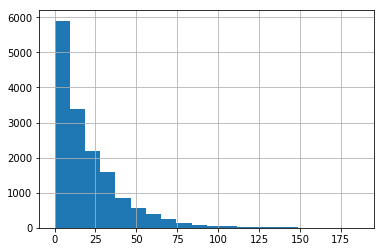

In [145]:
df_peps["Length"].hist(bins=20)

In [146]:
# so (not surprisingly) the typical length of a translated peptide from a random sequence is ~20 
# (since 3/64 ~ 1/20th of all translated codons are stop codons.
df_peps["Length"].describe()


count    15556.000000
mean        20.428002
std         20.849506
min          0.000000
25%          6.000000
50%         14.000000
75%         29.000000
max        186.000000
Name: Length, dtype: float64

# assignment (due next Thursday):
## think of a way (or look up) a way to produce a random sequence that has a higher GC content than the equal 25-25-25-25 that we have just analysed.
## hint: try googling stack-overflow.  also, what happens if "your_letters" has more than one copy of each DNA letter?
## specific question: "describe" the random translation of a string of 999999 letters with GC content of 0.667 = 2/3.

# return to our annotations, and now add the CDS and peptide to the table

In [147]:
annot.head()

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase
4,chr,NC_000913.3,5234,5530,+,944747,yaaX,b0005,NP_414546.1,98,-,DUF2502 domain-containing protein YaaX


In [184]:
CDS = []
peptide = []
for index, row in annot.iterrows():
    if ( row["Strand"] == "+" ):
        CDS_row = genome[row["Start"]-1 : row["Stop"]]
    if ( row["Strand"] == "-" ):
        CDS_row = revcomp( genome[row["Start"]-1 : row["Stop"]] ) 
    CDS.append( CDS_row )
    peptide.append( translate(CDS_row) )
annot["CDS"] = CDS
annot["peptide"] = peptide
annot.head(10)

KeyError: 'GA'

In [ ]:
# we screwed up, presumably on the opposite strand
# add debugging

In [185]:
CDS = []
peptide = []
for index, row in annot.iterrows():
    if ( row["Strand"] == "+" ):
        CDS_row = genome[row["Start"]-1 : row["Stop"]]
    if ( row["Strand"] == "-" ):
        CDS_row = genome[row["Stop"]-1 : row["Start"]] 
    print(index, row["Strand"], len(CDS_row))
    CDS.append( CDS_row )
    peptide.append( translate(CDS_row) )
annot["CDS"] = CDS
annot["peptide"] = peptide
annot.head(10)

0 + 66
1 + 2463
2 + 933
3 + 1287
4 + 297
5 - 0
6 - 0
7 + 954
8 + 588
9 - 0
10 - 0
11 + 486
12 - 0
13 + 1917
14 + 1131
15 + 1113
16 - 0
17 - 0
18 + 1167
19 + 906
20 - 0
21 - 0
22 - 0
23 + 219
24 + 942
25 + 2817
26 + 495
27 + 450
28 + 951
29 + 915
30 + 822
31 + 1149
32 + 3222
33 + 396
34 - 0
35 - 0
36 - 0
37 - 0
38 - 0
39 - 0
40 + 771
41 + 942
42 + 1287
43 + 288
44 + 1332
45 + 531
46 + 1863
47 + 480
48 - 0
49 - 0
50 - 0
51 - 0
52 - 0
53 - 0
54 + 816
55 + 651
56 + 159
57 - 0
58 - 0
59 - 0
60 - 0
61 - 0
62 - 0
63 + 879
64 + 765
65 - 0
66 - 0
67 - 0
68 - 0
69 + 132
70 + 1179
71 - 0
72 - 0
73 - 0
74 - 0
75 - 0
76 + 945
77 - 0
78 + 1725
79 + 492
80 + 1005
81 + 459
82 + 942
83 + 366
84 + 1767
85 + 1488
86 + 1359
87 + 1083
88 + 1317
89 + 1245
90 + 1068
91 + 1476
92 + 921
93 + 831
94 + 1263
95 + 1152
96 + 918
97 + 513
98 + 2706
99 + 390
100 - 0
101 - 0
102 - 0
103 + 45
104 + 1044
105 - 0
106 - 0
107 - 0
108 - 0
109 + 552
110 + 855
111 - 0
112 + 765
113 + 2664
114 + 1893
115 + 1425
116 - 0
117 + 

KeyError: 'GA'

In [154]:
annot.iloc[452]

#Replicon Name                                     chr
Replicon Accession                         NC_000913.3
Start                                           492092
Stop                                            493386
Strand                                               +
GeneID                                          945105
Locus                                             dnaX
Locus tag                                        b0470
Protein product                         YP_009518751.1
Length                                             431
COG(s)                                               -
Protein name          DNA polymerase III subunit gamma
Name: 452, dtype: object

In [155]:
# a plus strand!
493386-492092+1

1295

In [197]:
# this is not a multiple of three!  ERROR in the input file.
# we can look at this mroe carefully, but for now lets flag such problems
CDS = []
peptide = []
for index, row in annot.iterrows():
    if ( row["Strand"] == "+" ):
        CDS_row = genome[row["Start"]-1 : row["Stop"]]
    if ( row["Strand"] == "-" ):
        CDS_row_rev = genome[row["Start"]-1 : row["Stop"] : 1] 
        CDS_row =  revcomp( CDS_row_rev )
#   check for multiple of three. if not, make a dummy entry
    if ( len(CDS_row)%3 != 0):
        print(index, row["Strand"], len(CDS_row), row["Locus"])
        CDS_row = ''
    CDS.append( CDS_row )
    peptide.append( translate(CDS_row) )
annot["CDS"] = CDS
annot["peptide"] = peptide
annot.head(10)

452 + 1295 dnaX
467 - 212 copA
2800 - 1099 prfB


,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name,CDS,peptide
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,MKRISTTITTTITITTGNGAG_
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...
4,chr,NC_000913.3,5234,5530,+,944747,yaaX,b0005,NP_414546.1,98,-,DUF2502 domain-containing protein YaaX,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,VKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...
5,chr,NC_000913.3,5683,6459,-,944749,yaaA,b0006,NP_414547.1,258,-,peroxide stress resistance protein YaaA,ATGCTGATTCTTATTTCACCTGCGAAAACGCTTGATTACCAAAGCC...,MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQI...
6,chr,NC_000913.3,6529,7959,-,944745,yaaJ,b0007,NP_414548.1,476,-,putative transporter YaaJ,ATGCCAGATTTTTTCTCCTTCATTAACAGCGTCCTTTGGGGATCGG...,MPDFFSFINSVLWGSVMIYLLFGAGCWFTFRTGFVQFRYIRQFGKS...
7,chr,NC_000913.3,8238,9191,+,944748,talB,b0008,NP_414549.1,317,-,transaldolase B,ATGACGGACAAATTGACCTCCCTTCGTCAGTACACCACCGTAGTGG...,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...
8,chr,NC_000913.3,9306,9893,+,944760,mog,b0009,NP_414550.1,195,-,molybdopterin adenylyltransferase,ATGAATACTTTACGTATTGGCTTAGTTTCCATCTCTGATCGCGCAT...,MNTLRIGLVSISDRASSGVYQDKGIPALEEWLTSALTTPFELETRL...
9,chr,NC_000913.3,9928,10494,-,944792,satP,b0010,NP_414551.1,188,-,acetate/succinate:H(+) symporter,ATGGGCAACACTAAGTTGGCTAATCCGGCACCGCTGGGCCTGATGG...,MGNTKLANPAPLGLMGFGMTTILLNLHNVGYFALDGIILAMGIFYG...


In [ ]:
## k-mers

In [40]:
nucleotides = ['A','C','G','T']

In [54]:
# add on to a given list
def tack_on(list, alphabet):
    list2 = []
    for i in list:
        for j in alphabet:
            list2.append(i+j)
    return list2

['AA',
 'AC',
 'AG',
 'AT',
 'CA',
 'CC',
 'CG',
 'CT',
 'GA',
 'GC',
 'GG',
 'GT',
 'TA',
 'TC',
 'TG',
 'TT']

In [60]:
# test it!
list = nucleotides
tack_on(list, nucleotides)

['AA',
 'AC',
 'AG',
 'AT',
 'CA',
 'CC',
 'CG',
 'CT',
 'GA',
 'GC',
 'GG',
 'GT',
 'TA',
 'TC',
 'TG',
 'TT']

In [61]:
print(list)

['A', 'C', 'G', 'T']


In [57]:
list = tack_on(list, nucleotides)

In [58]:
print(list)

['AAAA', 'AAAC', 'AAAG', 'AAAT', 'AACA', 'AACC', 'AACG', 'AACT', 'AAGA', 'AAGC', 'AAGG', 'AAGT', 'AATA', 'AATC', 'AATG', 'AATT', 'ACAA', 'ACAC', 'ACAG', 'ACAT', 'ACCA', 'ACCC', 'ACCG', 'ACCT', 'ACGA', 'ACGC', 'ACGG', 'ACGT', 'ACTA', 'ACTC', 'ACTG', 'ACTT', 'AGAA', 'AGAC', 'AGAG', 'AGAT', 'AGCA', 'AGCC', 'AGCG', 'AGCT', 'AGGA', 'AGGC', 'AGGG', 'AGGT', 'AGTA', 'AGTC', 'AGTG', 'AGTT', 'ATAA', 'ATAC', 'ATAG', 'ATAT', 'ATCA', 'ATCC', 'ATCG', 'ATCT', 'ATGA', 'ATGC', 'ATGG', 'ATGT', 'ATTA', 'ATTC', 'ATTG', 'ATTT', 'CAAA', 'CAAC', 'CAAG', 'CAAT', 'CACA', 'CACC', 'CACG', 'CACT', 'CAGA', 'CAGC', 'CAGG', 'CAGT', 'CATA', 'CATC', 'CATG', 'CATT', 'CCAA', 'CCAC', 'CCAG', 'CCAT', 'CCCA', 'CCCC', 'CCCG', 'CCCT', 'CCGA', 'CCGC', 'CCGG', 'CCGT', 'CCTA', 'CCTC', 'CCTG', 'CCTT', 'CGAA', 'CGAC', 'CGAG', 'CGAT', 'CGCA', 'CGCC', 'CGCG', 'CGCT', 'CGGA', 'CGGC', 'CGGG', 'CGGT', 'CGTA', 'CGTC', 'CGTG', 'CGTT', 'CTAA', 'CTAC', 'CTAG', 'CTAT', 'CTCA', 'CTCC', 'CTCG', 'CTCT', 'CTGA', 'CTGC', 'CTGG', 'CTGT', 'CTTA',

In [ ]:
# six frame translation
# given a 